# Guide to Data Classes in Python 3.7
> Credit: [Geir Arne Hjelle](https://realpython.com/team/gahjelle/) @[RealPython.com](https://realpython.com/python-data-classes/)

In [54]:
from dataclasses import dataclass

@dataclass
class DataClassCard:
    rank: str
    suit: str

A data class comes with basic functionality already implemented. For instance, you can instantiate, print, and compare data class instances straight out of the box:

In [55]:
queen_of_hearts = DataClassCard('Q', 'Hearts')
queen_of_hearts.rank

'Q'

In [56]:
queen_of_hearts

DataClassCard(rank='Q', suit='Hearts')

In [57]:
queen_of_hearts == DataClassCard('Q', 'Hearts')

True

Compare that to a regular class. A minimal regular class would look something like this:

In [58]:
class RegularCard:
    def __init__(self, rank, suit):
        self.rank = rank
        self.suit = suit

While this is not much more code to write, you can already see signs of the boilerplate pain: rank and suit are both repeated three times simply to initialize an object. Furthermore, if you try to use this plain class, you’ll notice that the representation of the objects is not very descriptive, and for some reason a queen of hearts is not the same as a queen of hearts:

In [59]:
queen_of_hearts = RegularCard('Q', 'Hearts')
queen_of_hearts.rank

'Q'

In [60]:
queen_of_hearts

In [61]:
queen_of_hearts == RegularCard('Q', 'Hearts')

False

Seems like data classes are helping us out behind the scenes. By default, data classes implement a .__repr__() method to provide a nice string representation and an .__eq__() method that can do basic object comparisons. For the RegularCard class to imitate the data class above, you need to add these methods as well:

In [70]:
class RegularCard:
    def __init__(self, rank, suit):
        self.rank = rank
        self.suit = suit

    def __repr__(self):
        return (f'{self.__class__.__name__}'
                f'(rank={self.rank!r}, suit={self.suit!r})')

    def __eq__(self, other):
        if other.__class__ is not self.__class__:
            return NotImplemented
        return (self.rank, self.suit) == (other.rank, other.suit)

In this tutorial, you will learn exactly which conveniences data classes provide. In addition to nice representations and comparisons, you’ll see:

- How to add default values to data class fields
- How data classes allow for ordering of objects
- How to represent immutable data
- How data classes handle inheritance

***
# Basic Data Classes
Let us get back to data classes. As an example, we will create a Position class that will represent geographic positions with a name as well as the latitude and longitude:

In [72]:
from dataclasses import dataclass

@dataclass
class Position:
    name: str
    lon: float
    lat: float

What makes this a data class is the @dataclass decorator just above the class definition. Beneath the class Position: line, you simply list the fields you want in your data class. The : notation used for the fields is using a new feature in Python 3.6 called variable annotations. We will soon talk more about this notation and why we specify data types like str and float.

Those few lines of code are all you need. The new class is ready for use:

In [73]:
pos = Position('Oslo', 10.8, 59.9)
print(pos)

Position(name='Oslo', lon=10.8, lat=59.9)


In [74]:
pos.lat

59.9

In [75]:
print(f'{pos.name} is at {pos.lat}°N, {pos.lon}°E')

Oslo is at 59.9°N, 10.8°E


**You can also create data classes similarly to how named tuples are created. The following is (almost) equivalent to the definition of Position above:**

In [131]:
from dataclasses import make_dataclass

Position = make_dataclass('Position', ['name', 'lat', 'lon'])
pos_1 = Position('Oslo', 10.8, 59.9)
pos_2 = Position(name='Munich', lat=None, lon=10.9)
print(pos_1, pos_2)
print(type(pos_2))

Position(name='Oslo', lat=10.8, lon=59.9) Position(name='Munich', lat=None, lon=10.9)
<class 'types.Position'>


A data class is a regular Python class. The only thing that sets it apart is that it has basic data model methods like .__init__(), .__repr__(), and .__eq__() implemented for you.

## Default Values
It is easy to add default values to the fields of your data class:

In [118]:
from dataclasses import dataclass

@dataclass
class Position:
    name: str
    lon: float = 0.0
    lat: float = 0.0

This works exactly as if you had specified the default values in the definition of the .__init__() method of a regular class:

In [119]:
Position('Null Island')

Position(name='Null Island', lon=0.0, lat=0.0)

In [120]:
Position('Greenwich', lat=51.8)

Position(name='Greenwich', lon=0.0, lat=51.8)

In [121]:
Position('Vancouver', -123.1, 49.3)

Position(name='Vancouver', lon=-123.1, lat=49.3)

Later you will learn about default_factory, which gives a way to provide more complicated default values.

## Type Hints
So far, we have not made a big fuss of the fact that data classes support typing out of the box. You have probably noticed that we defined the fields with a type hint: name: str says that name should be a text string (str type).

In fact, adding some kind of type hint is mandatory when defining the fields in your data class. Without a type hint, the field will not be a part of the data class. However, if you do not want to add explicit types to your data class, use typing.Any:

In [122]:
from dataclasses import dataclass
from typing import Any

@dataclass
class WithoutExplicitTypes:
    name: Any
    value: Any = 42

While you need to add type hints in some form when using data classes, these types are not enforced at runtime. The following code runs without any problems:

In [123]:
Position(3.14, 'pi day', 2018)

Position(name=3.14, lon='pi day', lat=2018)

This is how typing in Python usually works: Python is and will always be a dynamically typed language. To actually catch type errors, type checkers like Mypy can be run on your source code.

## Adding Methods
You already know that a data class is just a regular class. That means that you can freely add your own methods to a data class. As an example, let us calculate the distance between one position and another, along the Earth’s surface. One way to do this is by using the haversine formula:

You can add a .distance_to() method to your data class just like you can with normal classes:

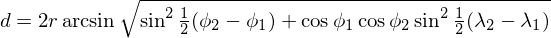

In [124]:
from IPython.display import Image
Image(filename='./haversine_formula_150.fb2b87d122a4.png') 

In [125]:
from dataclasses import dataclass
from math import asin, cos, radians, sin, sqrt

@dataclass
class Position:
    name: str
    lon: float = 0.0
    lat: float = 0.0

    def distance_to(self, other):
        r = 6371  # Earth radius in kilometers
        lam_1, lam_2 = radians(self.lon), radians(other.lon)
        phi_1, phi_2 = radians(self.lat), radians(other.lat)
        h = (sin((phi_2 - phi_1) / 2)**2
             + cos(phi_1) * cos(phi_2) * sin((lam_2 - lam_1) / 2)**2)
        return 2 * r * asin(sqrt(h))

In [127]:
oslo = Position('Oslo', 10.8, 59.9)
vancouver = Position('Vancouver', -123.1, 49.3)
oslo.distance_to(vancouver)

7181.784122942119

***
# More Flexible Data Classes
So far, you have seen some of the basic features of the data class: it gives you some convenience methods, and you can still add default values and other methods. Now you will learn about some more advanced features like parameters to the @dataclass decorator and the field() function. Together, they give you more control when creating a data class.

Let us return to the playing card example you saw at the beginning of the tutorial and add a class containing a deck of cards while we are at it:

In [128]:
from dataclasses import dataclass
from typing import List

@dataclass
class PlayingCard:
    rank: str
    suit: str

@dataclass
class Deck:
    cards: List[PlayingCard]

In [129]:
# A simple deck containing only two cards can be created like this:
queen_of_hearts = PlayingCard('Q', 'Hearts')
ace_of_spades = PlayingCard('A', 'Spades')
two_cards = Deck([queen_of_hearts, ace_of_spades])

## Advanced Default Values
Say that you want to give a default value to the Deck. It would for example be convenient if Deck() created a regular (French) deck of 52 playing cards. First, specify the different ranks and suits. Then, add a function make_french_deck() that creates a list of instances of PlayingCard:

In [130]:
RANKS = '2 3 4 5 6 7 8 9 10 J Q K A'.split()
SUITS = '♣ ♢ ♡ ♠'.split()

def make_french_deck():
    return [PlayingCard(r, s) for s in SUITS for r in RANKS]

For fun, the four different suits are specified using their Unicode symbols.

>Note: Above, we used Unicode glyphs like ♠ directly in the source code. We could do this because Python supports writing source code in UTF-8 by default. Refer to this page on Unicode input for how to enter these on your system. You could also enter the Unicode symbols for the suits using \N named character escapes (like \N{BLACK SPADE SUIT}) or \u Unicode escapes (like \u2660).

To simplify comparisons of cards later, the ranks and suits are also listed in their usual order.

In [93]:
make_french_deck()[:5]

[PlayingCard(rank='2', suit='♣'),
 PlayingCard(rank='3', suit='♣'),
 PlayingCard(rank='4', suit='♣'),
 PlayingCard(rank='5', suit='♣'),
 PlayingCard(rank='6', suit='♣')]

In [94]:
# In theory, you could now use this function to specify a default value for Deck.cards:
from dataclasses import dataclass
from typing import List

@dataclass
class Deck:  # Will NOT work
    cards: List[PlayingCard] = make_french_deck()

ValueError: mutable default <class 'list'> for field cards is not allowed: use default_factory

**Don’t do this!** - This introduces one of the most common anti-patterns in Python: using mutable default arguments. 

The problem is that all instances of Deck will use the same list object as the default value of the .cards property. This means that if, say, one card is removed from one Deck, then it disappears from all other instances of Deck as well. Actually, data classes try to prevent you from doing this, and the code above will raise a ValueError.

Instead, data classes use something called a default_factory to handle mutable default values. To use default_factory (and many other cool features of data classes), you need to use the field() specifier:

In [95]:
from dataclasses import dataclass, field
from typing import List

@dataclass
class Deck:
    cards: List[PlayingCard] = field(default_factory=make_french_deck)

In [98]:
# The argument to default_factory can be any zero parameter callable. Now it is easy to create a full deck of playing cards:
Deck()

Deck(cards=[PlayingCard(rank='2', suit='♣'), PlayingCard(rank='3', suit='♣'), PlayingCard(rank='4', suit='♣'), PlayingCard(rank='5', suit='♣'), PlayingCard(rank='6', suit='♣'), PlayingCard(rank='7', suit='♣'), PlayingCard(rank='8', suit='♣'), PlayingCard(rank='9', suit='♣'), PlayingCard(rank='10', suit='♣'), PlayingCard(rank='J', suit='♣'), PlayingCard(rank='Q', suit='♣'), PlayingCard(rank='K', suit='♣'), PlayingCard(rank='A', suit='♣'), PlayingCard(rank='2', suit='♢'), PlayingCard(rank='3', suit='♢'), PlayingCard(rank='4', suit='♢'), PlayingCard(rank='5', suit='♢'), PlayingCard(rank='6', suit='♢'), PlayingCard(rank='7', suit='♢'), PlayingCard(rank='8', suit='♢'), PlayingCard(rank='9', suit='♢'), PlayingCard(rank='10', suit='♢'), PlayingCard(rank='J', suit='♢'), PlayingCard(rank='Q', suit='♢'), PlayingCard(rank='K', suit='♢'), PlayingCard(rank='A', suit='♢'), PlayingCard(rank='2', suit='♡'), PlayingCard(rank='3', suit='♡'), PlayingCard(rank='4', suit='♡'), PlayingCard(rank='5', suit='♡

In [99]:
queen_of_hearts = PlayingCard('Q', '♡')
ace_of_spades = PlayingCard('A', '♠')
ace_of_spades > queen_of_hearts

TypeError: '>' not supported between instances of 'PlayingCard' and 'PlayingCard'

In [100]:
# This is, however, (seemingly) easy to rectify:
from dataclasses import dataclass

@dataclass(order=True)
class PlayingCard:
    rank: str
    suit: str

    def __str__(self):
        return f'{self.suit}{self.rank}'

In [101]:
queen_of_hearts = PlayingCard('Q', '♡')
ace_of_spades = PlayingCard('A', '♠')
ace_of_spades > queen_of_hearts

False

***
# Inheritance
You can subclass data classes quite freely. As an example, we will extend our Position example with a country field and use it to record capitals:

In [102]:
from dataclasses import dataclass

@dataclass
class Position:
    name: str
    lon: float
    lat: float

@dataclass
class Capital(Position):
    country: str

In [103]:
Capital('Oslo', 10.8, 59.9, 'Norway')

Capital(name='Oslo', lon=10.8, lat=59.9, country='Norway')

The country field of Capital is added after the three original fields in Position. Things get a little more complicated if any fields in the base class have default values:

In [104]:
# This code will immediately crash with a TypeError complaining that:
# “non-default argument ‘country’ follows default argument.”
from dataclasses import dataclass

@dataclass
class Position:
    name: str
    lon: float = 0.0
    lat: float = 0.0

@dataclass
class Capital(Position):
    country: str  # Does NOT work

TypeError: non-default argument 'country' follows default argument

The problem is that our new country field has no default value, while the lon and lat fields have default values. The data class will try to write an .__init__() method with the following signature:

```def __init__(name: str, lon: float = 0.0, lat: float = 0.0, country: str):```
                ^
```SyntaxError: non-default argument follows default argument```

However, this is not valid Python. If a parameter has a default value, all following parameters must also have a default value. In other words, if a field in a base class has a default value, then all new fields added in a subclass must have default values as well.

Another thing to be aware of is how fields are ordered in a subclass. Starting with the base class, fields are ordered in the order in which they are first defined. If a field is redefined in a subclass, its order does not change. For example, if you define Position and Capital as follows:

In [105]:
from dataclasses import dataclass

@dataclass
class Position:
    name: str
    lon: float = 0.0
    lat: float = 0.0

@dataclass
class Capital(Position):
    country: str = 'Unknown'
    lat: float = 40.0

Then the order of the fields in Capital will still be name, lon, lat, country. However, the default value of lat will be 40.0.

In [106]:
Capital('Madrid', country='Spain')

Capital(name='Madrid', lon=0.0, lat=40.0, country='Spain')

***
# Optimizing Data Classes
I’m going to end this tutorial with a few words about slots. Slots can be used to make classes faster and use less memory. Data classes have no explicit syntax for working with slots, but the normal way of creating slots works for data classes as well. (They really are just regular classes!)

In [107]:
from dataclasses import dataclass

@dataclass
class SimplePosition:
    name: str
    lon: float
    lat: float

@dataclass
class SlotPosition:
    __slots__ = ['name', 'lon', 'lat']
    name: str
    lon: float
    lat: float

Essentially, slots are defined using ```.__slots__``` to list the variables on a class. Variables or attributes not present in ```.__slots__``` may not be defined. Furthermore, a slots class may not have default values.

The benefit of adding such restrictions is that certain optimizations may be done. For instance, slots classes take up less memory, as can be measured using Pympler:

In [108]:
from pympler import asizeof
simple = SimplePosition('London', -0.1, 51.5)
slot = SlotPosition('Madrid', -3.7, 40.4)
asizeof.asizesof(simple, slot)

(440, 168)

Similarly, slots classes are typically faster to work with. The following example measures the speed of attribute access on a slots data class and a regular data class using timeit from the standard library.

In [109]:
from timeit import timeit

simple_pos = timeit('simple.name', setup="simple=SimplePosition('Oslo', 10.8, 59.9)", globals=globals())
slot_pos = timeit('slot.name', setup="slot=SlotPosition('Oslo', 10.8, 59.9)", globals=globals())

print(f"Simple Pos: {simple_pos:.4}")
print(f"Slot Pos: {slot_pos:.4}")
print(f"In this particular example, the slot class is about {(1-slot_pos/simple_pos) * 100:.0f}% faster.")


Simple Pos: 0.04695
Slot Pos: 0.03723
In this particular example, the slot class is about 21% faster.
